In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch

import sys
sys.path.insert(0, '../trainingdata')
from datasaver import *
sys.path.insert(0, '../testproblems/darcy')
from ManufacturedSolutionsDarcy import *
sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from NGO import NGO
from customlosses import *
from quadrature import *

In [2]:
%load_ext autoreload
%autoreload 2

### FEM test dataset

In [3]:
# #Test dataset
# N_samples = 1000
# theta = load_function_list('theta', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
# f = load_function_list('f', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
# etab = load_function_list('etab', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
# etat = load_function_list('etat', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
# x = np.load('../../../trainingdata/VarMiONpaperdata/test/x.npy')[:N_samples]
# u_exact = np.load('../../../trainingdata/VarMiONpaperdata/test/u.npy')[:N_samples]
# def g0(x):
#     return np.zeros(x.shape[0])
# g0set = []
# for i in range(N_samples): 
#     g0set.append(g0)
# gl = g0set
# gr = g0set
# x = x[0]

### Manufactured solutions test dataset

In [46]:
N_samples = 1000

dataset = MFSetDarcy(N_samples=N_samples, d=2, l_min=0.1, l_max=0.2)
# dataset = MFSetDarcy(N_samples=N_samples, d=2, l_theta_min=0.2, l_theta_max=0.4, l_u_min=0.2/2, l_u_max=0.4/2)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
# x = np.load('../../../trainingdata/VarMiONpaperdata/test/x.npy')[:N_samples]
# x = x[0]

# u_exact = []
# for i in range(len(u)):
#     u_exact.append(u[i](x))
# u_exact = np.array(u_exact)

### Test error histograms

In [6]:
# from NGO import NGO

# logdir = '../../../nnlogs'
# map_location = 'cpu'

# sublogdir = 'basisfunctions'

# bsplinesproj = loadmodelfromlabel(model=NGO, label='bsplines', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# bsplinesproj.hparams['modeltype'] = 'projection'
# bsplinesfem = loadmodelfromlabel(model=NGO, label='bsplines', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# bsplinesfem.hparams['modeltype'] = 'FEM'
# bsplinesngo = loadmodelfromlabel(model=NGO, label='bsplines', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

# chebyshevproj = loadmodelfromlabel(model=NGO, label='chebyshev', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# chebyshevproj.hparams['modeltype'] = 'projection'
# chebyshevfem = loadmodelfromlabel(model=NGO, label='chebyshev', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# chebyshevfem.hparams['modeltype'] = 'FEM'
# chebyshevngo = loadmodelfromlabel(model=NGO, label='chebyshev', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

# modeldict = {'B-splines projection': bsplinesproj,
#              'B-splines FEM': bsplinesfem,
#              'B-splines NGO': bsplinesngo,
#              'Chebyshev projection': chebyshevproj,
#              'Chebyshev FEM': chebyshevfem,
#              'Chebyshev NGO': chebyshevngo,}


### Bulk

In [12]:
# size_title = 20
# size_ticklabels = 15
# size_axeslabels = 20

# fig, ax = plt.subplots(1,1, figsize=(6, 4))
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

# colors = ['grey', 'C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
# # quadrature = GaussLegendreQuadrature2D(Q=100, n_elements=5)
# # x = quadrature.xi_Omega
# # w = quadrature.w_Omega

# # u_exact = []
# # for i in range(len(u)):
# #     u_exact.append(u[i](x))
# # u_exact = np.array(u_exact)

# j=0
# for model in modeldict:
#     print(str(model))
#     u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, x, u)
#     # L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
#     L22_diff = np.sum((u_hat - u_exact)**2, axis=-1)
#     L2_diff = L22_diff**(1/2)
#     # L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
#     L22_norm = np.sum((u_exact)**2, axis=-1)
#     L2_norm = L22_norm**(1/2)
#     L2_scaled = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
#     L2_scaled_avg = np.average(L2_scaled)
#     sigma = np.std(L2_scaled)
#     ax.hist(L2_scaled, bins=np.logspace(-5,0,100), density=False, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
#     # ax.hist(L2_scaled, bins=100, density=False, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
#     ax.axvline(L2_scaled_avg, 0, 1, linewidth=3, linestyle='--', color=colors[j], label=format(L2_scaled_avg, f".{1}e")+r'$\pm$'+format(sigma, f".{1}e")+' '+str(model))
#     j+=1
# ax.legend(fontsize=15)
# ax.tick_params(axis='both', labelsize=size_ticklabels)
# ax.set_xlabel(r'Relative L2 error', fontsize=size_axeslabels)
# ax.set_ylabel(r'Counts', fontsize=size_axeslabels)
# ax.grid()
# ax.set_xscale('log')
# # ax.set_yscale('log')

# plt.savefig("FEMdata.svg", bbox_inches='tight')

### Accuracy different FEMs versus $\gamma$

In [4]:
from NGO import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

sublogdir = 'modelvsdata'

model = loadmodelfromlabel(model=NGO, label='model', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

modeldict = {'Model NGO': model}

N_samples = 1
l_min = 1
l_max = 1

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

quadrature = GaussLegendreQuadrature2D(Q=132, n_elements=4)
x = quadrature.xi_Omega
w = quadrature.w_Omega

In [14]:
gammas = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])

L2_scaled_avg = np.zeros((len(modeldict),len(gammas)))
yerr = np.zeros((len(modeldict),2,len(gammas)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 25

linestyles=['--','--','--','--','--','--','--']

colors = ['C0','C1','C2','C3','C4','C5','C6']

dataset = MFSetDarcy(N_samples=N_samples, d=2, l_min=l_min, l_max=l_max)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u

u_exact = []
for i in range(len(u)):
    u_exact.append(u[i](x))
u_exact = np.array(u_exact)

for i in range(len(gammas)):
    print(gammas[i])
    m=0
    for model in modeldict:
        modeldict[str(model)].hparams['gamma_stabilization'] = gammas[i]
        u_hat = modeldict[str(model)].simforward(theta_test, f_test, etab_test, etat_test, gl_test, gr_test, x_test, u_test)
        L2 = np.linalg.norm(u_hat - u_exact, ord=2, axis=-1)
        norm = np.linalg.norm(u_exact, ord=2, axis=-1)
        L2_scaled_array = (L2/norm)
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
        m+=1
        
fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
# plots.append(ax.axvspan(0.5,1, color='black', alpha=0.1, label='Training data range'))
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'$\lambda/L$', fontsize=size_axeslabels)
# ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(0, 1.05)
# ax.set_ylim(1e-4, 1e4)
# ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
# ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.grid()
for model in modeldict:
    plots.append(ax.errorbar(gammas, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
        # plt.savefig(str(m)+".svg", bbox_inches='tight')#, transparent=True)
    m+=1
    # plt.legend(fontsize=10, loc='upper right')
    # plt.savefig(str(m)+".svg", bbox_inches='tight')#, transparent=True)
plt.legend(fontsize=10, loc='upper right')
# legend1 = ax.legend(handles=[plots[0],plots[1],plots[2],plots[3],plots[4],plo],fontsize=10, loc='upper right')
# plt.gca().add_artist(legend1)
# plt.legend(handles=[plots[7]],fontsize=10, loc='lower left')
plt.savefig("all.svg", bbox_inches='tight')#, transparent=True)

plt.show()

In [3]:
from NGO import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

models = ['Q_GLperelement', 'Q_GLperdomain', 'Q_Uperdomain']
labels = ['GL per element', 'GL per domain', 'U per domain']
values = [3, 6, 15, 30, 60, 99, 150]

N_samples = 100
l_min = 0.1
l_max = 0.1

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

quadrature = GaussLegendreQuadrature2D(Q=99, n_elements=3)
x = quadrature.xi_Omega
w = quadrature.w_Omega


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67


KeyboardInterrupt: 

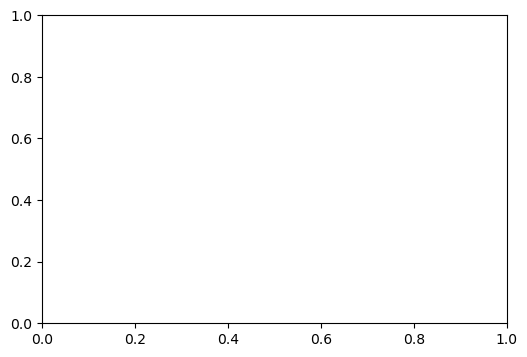

In [4]:
L2_scaled_avg = np.zeros((len(models),len(values)))
yerr = np.zeros((len(models),2,len(values)))

linestyles = ['--','--','--','--','--']
colors = ['C0','C1','C2','C1','C2','C2','C4','C5','C6']

dataset = MFSetDarcy(N_samples=N_samples, d=2, l_min=l_min, l_max=l_max)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
u_exact = []
for j in range(len(u)):
    u_exact.append(u[j](x))
u_exact = np.array(u_exact)

size_title = 25
size_ticklabels = 15
size_axeslabels = 25

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        model.hparams['modeltype'] = 'FEM'
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

plots = []
for m in range(len(models)):
    # plots.append(ax.plot(values, L2_scaled_avg[m], color=colors[m], marker='^', label='Projection '+labels[m], linestyle='-'))
    ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], capsize=6, ms=8, label='FEM '+labels[m], color=colors[m], linestyle='-', marker='s')

for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

for m in range(len(models)):
    # plots.append(ax.plot(values, L2_scaled_avg[m], color=colors[m], marker='o', label=labels[m], linestyle='--'))
    ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m],  capsize=6, ms=8, label='NGO '+labels[m], color=colors[m], linestyle='--', marker='o')

ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_title(r'$\lambda=0.1$', fontsize=size_title)
ax.set_xlabel(r'$Q$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-6,1e1)
ax.grid()
plt.legend(fontsize=10)
plt.savefig("Q_lambda01_FEM.svg", bbox_inches='tight')#, transparent=True)
plt.show()

### Accuracy different NOs versus $\lambda$

In [4]:
from NGO import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

sublogdir = 'modelvsdata'

model = loadmodelfromlabel(model=NGO, label='model', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
data = loadmodelfromlabel(model=NGO, label='data', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
matrixdata = loadmodelfromlabel(model=NGO, label='matrixdata', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

proj = loadmodelfromlabel(model=NGO, label='model', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
proj.hparams['modeltype'] = 'projection'


modeldict = {'Projection': proj,
             'Model NGO': model,
             'Data NGO': data,
             'Matrix data NGO': matrixdata}

In [6]:
N_samples = 10

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

# l = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1])
# l = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5])
l = np.array([0.1,0.15,0.2,0.25,0.3])
# l = np.array([0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

# l = np.array([1])

# l = np.array([0.4, 0.3, 0.2, 0.1, 0.05])
L2_scaled_avg = np.zeros((len(modeldict),len(l)))
yerr = np.zeros((len(modeldict),2,len(l)))

size_title = 20
size_ticklabels = 15
size_axeslabels = 25

quadrature = GaussLegendreQuadrature2D(Q=132, n_elements=4)
x = quadrature.xi_Omega
w = quadrature.w_Omega

linestyles=['-','--','--','--','--','--']
colors = ['black','C0','C1','C2','C1','C2','C2','C4','C5','C6']
# markers = ['o','^','o','^','o','^','o']
    
for i in range(len(l)):
    print(l[i])
    dataset = MFSetDarcy(N_samples=N_samples, d=2, l_min=l[i], l_max=l[i])
    theta = dataset.theta
    f = dataset.f
    etat = dataset.etat
    etab = dataset.etab
    gl = dataset.gl
    gr = dataset.gr
    u = dataset.u
    u_exact = []
    for j in range(len(u)):
        u_exact.append(u[j](x))
    u_exact = np.array(u_exact)
    m=0
    for model in modeldict:
        print(str(model))
        u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, x, u)
    
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
        print(yerr[m,:,i])
        m+=1
        
fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
# plots.append(ax.axvspan(0.5,1, color='black', alpha=0.1, label='Training data range'))
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'$\lambda/L$', fontsize=size_axeslabels)
# ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_yscale('log')
# ax.set_xlim(0, 1.05)
# ax.set_ylim(1e-4, 1e4)
# ax.set_yticks([1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4])
# ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.grid()
for model in modeldict:
    # ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m], marker='o')
    plots.append(ax.errorbar(l, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
        # plt.savefig(str(m)+".svg", bbox_inches='tight')#, transparent=True)
    m+=1
    # plt.legend(fontsize=10, loc='upper right')
    # plt.savefig(str(m)+".svg", bbox_inches='tight')#, transparent=True)
plt.legend(fontsize=10)
# legend1 = ax.legend(handles=[plots[0],plots[2],plots[4]],fontsize=10, loc='upper right')
# plt.gca().add_artist(legend1)
# plt.legend(handles=[plots[1],plots[3]],fontsize=10, loc='lower left')
plt.savefig("modelvsdata.svg", bbox_inches='tight')#, transparent=True)

plt.show()

NameError: name 'modeldict' is not defined

### Parameter scan

In [20]:
from NGO import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

models = ['N_fixedquadrature']
# labels = ['GL per element', 'GL per domain', 'U per domain']
values = [16,25,36,49,64,81,100,121,144,169,196,225]

N_samples = 10
l_min = 0.1
l_max = 0.1

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

quadrature = GaussLegendreQuadrature2D(Q=99, n_elements=3)
x = quadrature.xi_Omega
w = quadrature.w_Omega


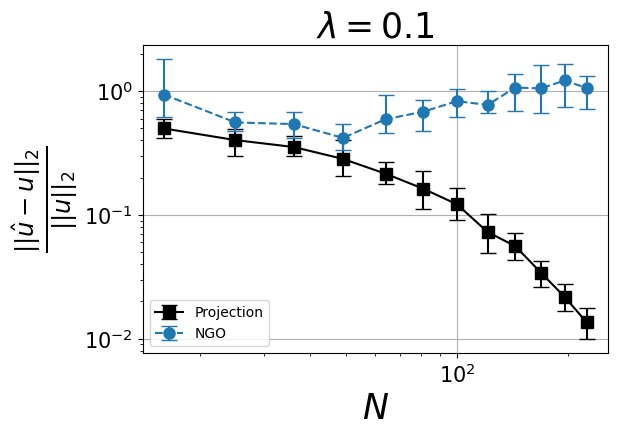

In [21]:
L2_scaled_avg = np.zeros((len(models),len(values)))
yerr = np.zeros((len(models),2,len(values)))

linestyles = ['--','--','--','--','--']
colors = ['C0','C1','C2','C1','C2','C2','C4','C5','C6']

dataset = MFSetDarcy(N_samples=N_samples, d=2, l_min=l_min, l_max=l_max)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
u_exact = []
for j in range(len(u)):
    u_exact.append(u[j](x))
u_exact = np.array(u_exact)

size_title = 25
size_ticklabels = 15
size_axeslabels = 25

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        model.hparams['modeltype'] = 'projection'
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

plots = []
for m in range(len(models)):
    # plots.append(ax.plot(values, L2_scaled_avg[m], color=colors[m], marker='^', label='Projection '+labels[m], linestyle='-'))
    ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], capsize=6, ms=8, label='Projection', color='black', linestyle='-', marker='s')

for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

for m in range(len(models)):
    # plots.append(ax.plot(values, L2_scaled_avg[m], color=colors[m], marker='o', label=labels[m], linestyle='--'))
    ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m],  capsize=6, ms=8, label='NGO', color='C0', linestyle='--', marker='o')

ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_title(r'$\lambda=0.1$', fontsize=size_title)
ax.set_xlabel(r'$N$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-6,1e1)
ax.grid()
plt.legend(fontsize=10)
plt.savefig("N_lambda01.svg", bbox_inches='tight')#, transparent=True)
plt.show()

In [10]:
from NGO import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

models = ['Q_GLperelement', 'Q_GLperdomain', 'Q_Uperdomain']
labels = ['GL per element', 'GL per domain', 'U per domain']
values = [3, 6, 15, 30, 60, 99, 150]

N_samples = 10
l_min = 0.1
l_max = 0.1

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

quadrature = GaussLegendreQuadrature2D(Q=99, n_elements=3)
x = quadrature.xi_Omega
w = quadrature.w_Omega


KeyboardInterrupt: 

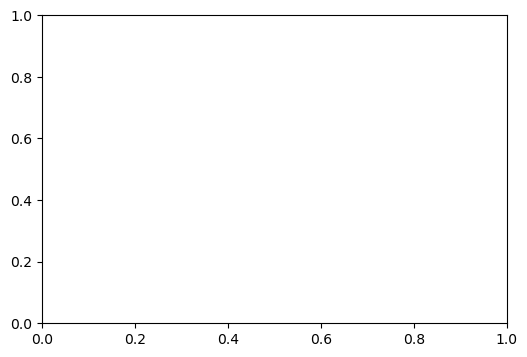

In [11]:
L2_scaled_avg = np.zeros((len(models),len(values)))
yerr = np.zeros((len(models),2,len(values)))

linestyles = ['--','--','--','--','--']
colors = ['C0','C1','C2','C1','C2','C2','C4','C5','C6']

dataset = MFSetDarcy(N_samples=N_samples, d=2, l_min=l_min, l_max=l_max)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
u_exact = []
for j in range(len(u)):
    u_exact.append(u[j](x))
u_exact = np.array(u_exact)

size_title = 25
size_ticklabels = 15
size_axeslabels = 25

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        model.hparams['modeltype'] = 'FEM'
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

plots = []
for m in range(len(models)):
    # plots.append(ax.plot(values, L2_scaled_avg[m], color=colors[m], marker='^', label='Projection '+labels[m], linestyle='-'))
    ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], capsize=6, ms=8, label='FEM '+labels[m], color=colors[m], linestyle='-', marker='s')

# for m in range(len(models)):
#     for i in range(len(values)):
#         model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
#         u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
#         L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
#         L2_diff = L22_diff**(1/2)
#         L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
#         L2_norm = L22_norm**(1/2)
#         L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
#         L2_scaled_avg[m,i] = np.average(L2_scaled_array)
#         q_l = np.quantile(L2_scaled_array, q_low)
#         q_h = np.quantile(L2_scaled_array, q_high)
#         yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

# for m in range(len(models)):
#     # plots.append(ax.plot(values, L2_scaled_avg[m], color=colors[m], marker='o', label=labels[m], linestyle='--'))
#     ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m],  capsize=6, ms=8, label='NGO '+labels[m], color=colors[m], linestyle='--', marker='o')

ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_title(r'$\lambda=1$', fontsize=size_title)
ax.set_xlabel(r'$Q$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-6,1e1)
ax.grid()
plt.legend(fontsize=10)
plt.savefig("Q_lambda1_FEM.svg", bbox_inches='tight')#, transparent=True)
plt.show()

In [24]:
from NGO import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

models = ['Q_L_GLperelement', 'Q_L_GLperdomain', 'Q_L_Uperdomain']
labels = ['GL per element', 'GL per domain', 'U per domain']

values = [3, 6, 15, 30, 60, 99, 150]

N_samples = 100
l_min = 0.1
l_max = 0.1

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

quadrature = GaussLegendreQuadrature2D(Q=99, n_elements=3)
x = quadrature.xi_Omega
w = quadrature.w_Omega


/tmp/ipykernel_47381/2794204944.py:43: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='Projection', color='black', linestyle='-'))
/tmp/ipykernel_47381/2794204944.py:61: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='NGO '+labels[m], color=colors[m], linestyle='--'))


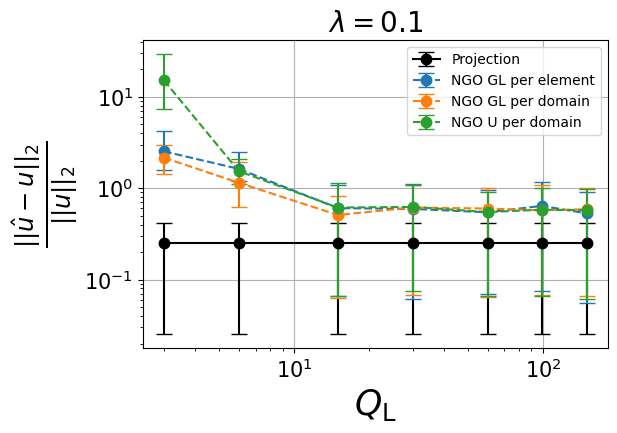

In [25]:
L2_scaled_avg = np.zeros((len(models),len(values)))
yerr = np.zeros((len(models),2,len(values)))

linestyles = ['--','--','--','--','--']
colors = ['C0','C1','C2','C1','C2','C2','C4','C5','C6']

size_title = 20
size_ticklabels = 15
size_axeslabels = 25

dataset = MFSetDarcy(N_samples=N_samples, d=2, l_min=l_min, l_max=l_max)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
u_exact = []
for j in range(len(u)):
    u_exact.append(u[j](x))
u_exact = np.array(u_exact)

for i in range(len(values)):
    model = loadmodelfromlabel(model=NGO, label='99', logdir=logdir, sublogdir='Q_GLperelement', map_location=map_location)
    model.hparams['modeltype'] = 'projection'
    u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
    L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
    L2_diff = L22_diff**(1/2)
    L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
    L2_norm = L22_norm**(1/2)
    L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
    L2_scaled_avg[m,i] = np.average(L2_scaled_array)
    q_l = np.quantile(L2_scaled_array, q_low)
    q_h = np.quantile(L2_scaled_array, q_high)
    yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
    # plots.append(ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m]))
plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='Projection', color='black', linestyle='-'))

for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

for m in range(len(models)):
    # plots.append(ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m]))
    plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='NGO '+labels[m], color=colors[m], linestyle='--'))

ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_title(r'$\lambda=0.1$', fontsize=size_title)
ax.set_xlabel(r'$Q_{\mathrm{L}}$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
plt.legend(handles=plots, fontsize=10)
plt.savefig("Q_L_lambda01.svg", bbox_inches='tight')#, transparent=True)

In [26]:
from NGO import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

models = ['N_w']

values = [1000, 2000, 5000, 10000, 20000, 50000, 100000]

N_samples = 100
l_min = 0.1
l_max = 0.1

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

quadrature = GaussLegendreQuadrature2D(Q=99, n_elements=3)
x = quadrature.xi_Omega
w = quadrature.w_Omega

/tmp/ipykernel_47381/1681017095.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='Projection', color='black', linestyle='-'))
/tmp/ipykernel_47381/1681017095.py:64: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='NGO', color=colors[m], linestyle='--'))


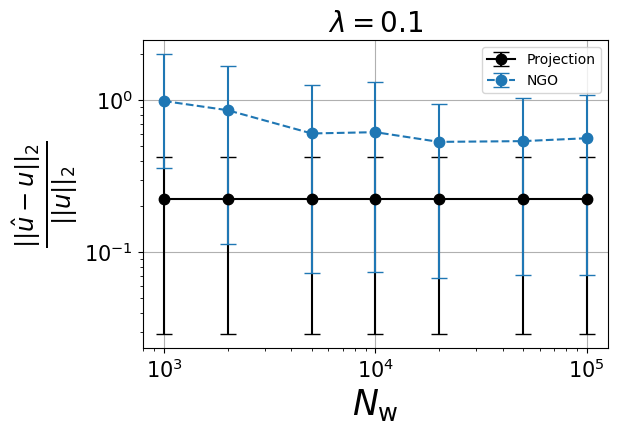

In [27]:
L2_scaled_avg = np.zeros((len(models),len(values)))
yerr = np.zeros((len(models),2,len(values)))

linestyles = ['--','--','--','--','--']
colors = ['C0','C1','C2','C1','C2','C2','C4','C5','C6']

size_title = 20
size_ticklabels = 15
size_axeslabels = 25

dataset = MFSetDarcy(N_samples=N_samples, d=2, l_min=l_min, l_max=l_max)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
u_exact = []
for j in range(len(u)):
    u_exact.append(u[j](x))
u_exact = np.array(u_exact)

for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        model.hparams['modeltype'] = 'projection'
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
for m in range(len(models)):
    # plots.append(ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m]))
    plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='Projection', color='black', linestyle='-'))


for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

for m in range(len(models)):
    # plots.append(ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m]))
    plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='NGO', color=colors[m], linestyle='--'))

ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_title(r'$\lambda=0.1$', fontsize=size_title)
ax.set_xlabel(r'$N_{\mathrm{w}}$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
plt.legend(handles=plots, fontsize=10)
plt.savefig("N_w_lambda01.svg", bbox_inches='tight')#, transparent=True)

In [28]:
from NGO import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

models = ['bottlenecksize']

values = [1,2,5,10,20,50,100]

N_samples = 100
l_min = 0.1
l_max = 0.1

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

quadrature = GaussLegendreQuadrature2D(Q=99, n_elements=3)
x = quadrature.xi_Omega
w = quadrature.w_Omega

/tmp/ipykernel_47381/227755843.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='Projection', color='black', linestyle='-'))
/tmp/ipykernel_47381/227755843.py:64: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='NGO', color=colors[m], linestyle='--'))


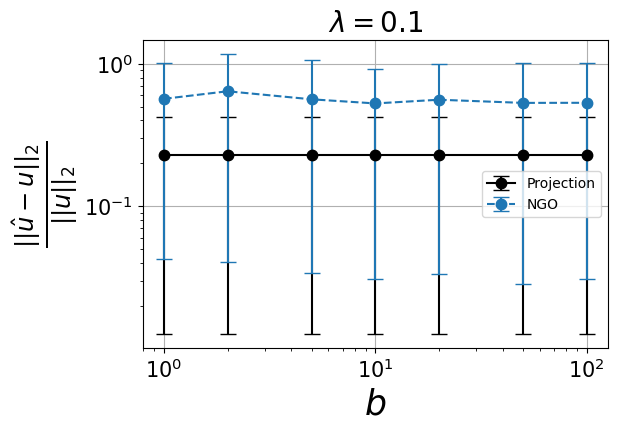

In [29]:
L2_scaled_avg = np.zeros((len(models),len(values)))
yerr = np.zeros((len(models),2,len(values)))

linestyles = ['--','--','--','--','--']
colors = ['C0','C1','C2','C1','C2','C2','C4','C5','C6']

size_title = 20
size_ticklabels = 15
size_axeslabels = 25

dataset = MFSetDarcy(N_samples=N_samples, d=2, l_min=l_min, l_max=l_max)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
u_exact = []
for j in range(len(u)):
    u_exact.append(u[j](x))
u_exact = np.array(u_exact)

for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        model.hparams['modeltype'] = 'projection'
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
for m in range(len(models)):
    # plots.append(ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m]))
    plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='Projection', color='black', linestyle='-'))


for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

for m in range(len(models)):
    # plots.append(ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m]))
    plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='NGO', color=colors[m], linestyle='--'))

ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_title(r'$\lambda=0.1$', fontsize=size_title)
ax.set_xlabel(r'$b$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
plt.legend(handles=plots, fontsize=10)
plt.savefig("b_lambda01.svg", bbox_inches='tight')#, transparent=True)

In [30]:
from NGO import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

models = ['N_epochs']

values = [1,2,5,10,20,50,100,200,500,1000,2000,5000,10000]#,20000,50000,100000]

N_samples = 100
l_min = 0.1
l_max = 0.1

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

quadrature = GaussLegendreQuadrature2D(Q=99, n_elements=3)
x = quadrature.xi_Omega
w = quadrature.w_Omega

In [31]:
L2_scaled_avg = np.zeros((len(models),len(values)))
yerr = np.zeros((len(models),2,len(values)))

linestyles = ['--','--','--','--','--']
colors = ['C0','C1','C2','C1','C2','C2','C4','C5','C6']

size_title = 20
size_ticklabels = 15
size_axeslabels = 25

dataset = MFSetDarcy(N_samples=N_samples, d=2, l_min=l_min, l_max=l_max)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
u_exact = []
for j in range(len(u)):
    u_exact.append(u[j](x))
u_exact = np.array(u_exact)

for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        model.hparams['modeltype'] = 'projection'
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
for m in range(len(models)):
    # plots.append(ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m]))
    plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='Projection', color='black', linestyle='-'))


for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

for m in range(len(models)):
    # plots.append(ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m]))
    plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='NGO', color=colors[m], linestyle='--'))

ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_title(r'$\lambda=0.1$', fontsize=size_title)
ax.set_xlabel(r'$N_{\mathrm{epochs}}$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
plt.legend(handles=plots, fontsize=10)
plt.savefig("N_epochs_lambda01.svg", bbox_inches='tight')#, transparent=True)

In [48]:
from NGO import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

models = ['N_samples']

values = [100,200,500,1000,2000,5000,10000,20000,50000,100000]

N_samples = 10
l_min = 0.1
l_max = 0.1

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

quadrature = GaussLegendreQuadrature2D(Q=99, n_elements=3)
x = quadrature.xi_Omega
w = quadrature.w_Omega

/tmp/ipykernel_2203721/2145972761.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='Projection', color='black', linestyle='-'))
/tmp/ipykernel_2203721/2145972761.py:64: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='NGO', color=colors[m], linestyle='--'))


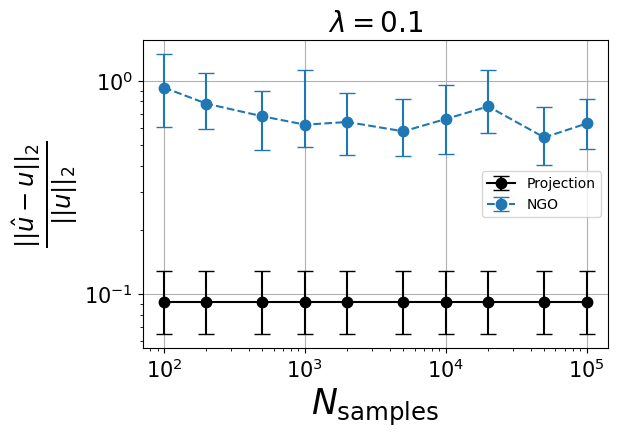

In [49]:
L2_scaled_avg = np.zeros((len(models),len(values)))
yerr = np.zeros((len(models),2,len(values)))

linestyles = ['--','--','--','--','--']
colors = ['C0','C1','C2','C1','C2','C2','C4','C5','C6']

size_title = 20
size_ticklabels = 15
size_axeslabels = 25

dataset = MFSetDarcy(N_samples=N_samples, d=2, l_min=l_min, l_max=l_max)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
u_exact = []
for j in range(len(u)):
    u_exact.append(u[j](x))
u_exact = np.array(u_exact)

for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        model.hparams['modeltype'] = 'projection'
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
for m in range(len(models)):
    # plots.append(ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m]))
    plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='Projection', color='black', linestyle='-'))


for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

for m in range(len(models)):
    # plots.append(ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m]))
    plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='NGO', color=colors[m], linestyle='--'))

ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_title(r'$\lambda=0.1$', fontsize=size_title)
ax.set_xlabel(r'$N_{\mathrm{samples}}$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
plt.legend(handles=plots, fontsize=10)
plt.savefig("N_samples_lambda01.svg", bbox_inches='tight')#, transparent=True)

In [76]:
from NGO import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

models = ['gamma_stabilization']

values = [0,1,2,5,10,20,50,100,200,500,1000]

N_samples = 10
l_min = 0.1
l_max = 0.1

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

quadrature = GaussLegendreQuadrature2D(Q=99, n_elements=3)
x = quadrature.xi_Omega
w = quadrature.w_Omega

/tmp/ipykernel_2203721/2079972167.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='Projection', color='black', linestyle='-'))
/tmp/ipykernel_2203721/2079972167.py:64: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='FEM', color='grey', linestyle='-'))
/tmp/ipykernel_2203721/2079972167.py:83: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6

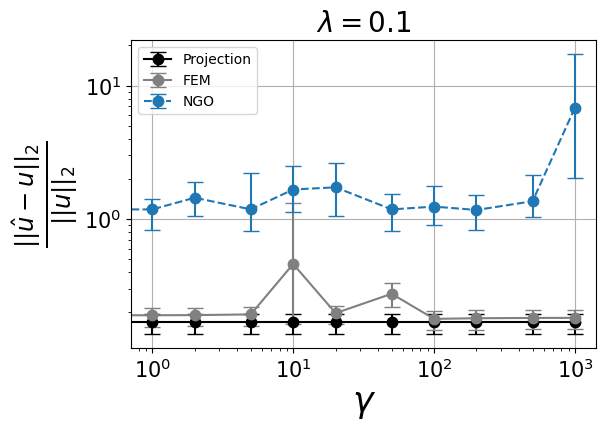

In [77]:
L2_scaled_avg = np.zeros((len(models),len(values)))
yerr = np.zeros((len(models),2,len(values)))

linestyles = ['--','--','--','--','--']
colors = ['C0','C1','C2','C1','C2','C2','C4','C5','C6']

size_title = 20
size_ticklabels = 15
size_axeslabels = 25

dataset = MFSetDarcy(N_samples=N_samples, d=2, l_min=l_min, l_max=l_max)
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
u_exact = []
for j in range(len(u)):
    u_exact.append(u[j](x))
u_exact = np.array(u_exact)

for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        model.hparams['modeltype'] = 'projection'
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
for m in range(len(models)):
    # plots.append(ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m]))
    plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='Projection', color='black', linestyle='-'))

for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        model.hparams['modeltype'] = 'FEM'
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

for m in range(len(models)):
    # plots.append(ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m]))
    plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='FEM', color='grey', linestyle='-'))


for m in range(len(models)):
    for i in range(len(values)):
        model = loadmodelfromlabel(model=NGO, label=str(values[i]), logdir=logdir, sublogdir=models[m], map_location=map_location)
        u_hat = model.simforward(theta, f, etab, etat, gl, gr, x, u)
        L22_diff = np.sum(w[None,:]*(u_hat - u_exact)**2, axis=-1)
        L2_diff = L22_diff**(1/2)
        L22_norm = np.sum(w[None,:]*(u_exact)**2, axis=-1)
        L2_norm = L22_norm**(1/2)
        L2_scaled_array = L2_diff/np.maximum(L2_norm, 1e-7*np.ones_like(L2_norm))
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])

for m in range(len(models)):
    # plots.append(ax.plot(l, L2_scaled_avg[m], color=colors[m], label=str(model), linestyle=linestyles[m]))
    plots.append(ax.errorbar(values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label='NGO', color=colors[m], linestyle='--'))

ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_title(r'$\lambda=0.1$', fontsize=size_title)
ax.set_xlabel(r'$\gamma$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
plt.legend(fontsize=10)
plt.savefig("gamma_lambda01.svg", bbox_inches='tight')#, transparent=True)